# Python and NetCDF climate data
Unlike MatLab, Python does not have native support for multidimensional NetCDF datasets. Instead, we have to import a few specific packages into our script and do a few extra steps to manipulate the data. The notebook below demonstrates the steps needed to import, link variables representing the different dimensions, and run simple analyses on netCDF data.  

In the example here, we'll use daily precipitation predictions downscaled to a 1/16-degree resolution spanning the years 1990 to 2005. Thus, our data has 4 dimensions: `latitude`, `longitude`, `time`, and `precipitation`. *(Actually, the dataset has a 5th "dimension" as well, but this only includes data on the geographic coordinate reference system and has only one value, so we'll ignore it)*. 

In [1]:
#Import packages
import netCDF4
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

In [2]:
#Read the file into a netCDF dataset object
fileName = 'macav2livneh_pr_bcc-csm1-1_r1i1p1_historical_1990_2005_CONUS_monthly.nc'
dataset = netCDF4.Dataset(fileName)

In [3]:
#Display the dimensions of the dataset
print (dataset.dimensions)

OrderedDict([('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 444
), ('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 922
), ('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 192
), ('crs', <class 'netCDF4._netCDF4.Dimension'>: name = 'crs', size = 1
)])


In [4]:
#Read the variables in NETCDF file
lon = dataset.variables['lon']
lat = dataset.variables['lat']
time = dataset.variables['time']
precip = dataset.variables['precipitation']

In [5]:
#Display info about a variable
print(precip)

<class 'netCDF4._netCDF4.Variable'>
float32 precipitation(time, lat, lon)
    _FillValue: -9999.0
    long_name: Monthly Precipitation Amount
    units: mm
    grid_mapping: crs
    standard_name: precipitation
    cell_methods: time: sum(interval: 24 hours): sum over days
    coordinates: time lon lat
    comments: Total monthly precipitation at surface: includes both liquid and solid phases from all types of clouds (both large-scale and convective)
unlimited dimensions: 
current shape = (192, 444, 922)
filling on


In [6]:
#Return the dimension size of the variable precip
[ntime,nlat,nlon] = dataset.variables['precipitation'].shape
print(ntime," time values")
print(nlat," latitude values")
print(nlon," longitude values")

192  time values
444  latitude values
922  longitude values


In [7]:
#Show the dimensions of the other variables
print("Time: ",time.shape)
print("Latitude: ",lat.shape)
print("Longitude: ",lon.shape)

Time:  (192,)
Latitude:  (444,)
Longitude:  (922,)


---
Let's pause and consider then what we have. First, the `precip` variable has 3 axes: `time`,`lat`, and `lon`, with sizes of 192, 444, and 922, respectively. And the value at a given time/geographic coordinate is the predicted rainfall at that specific time/location. We can extract a specific precipitation value by specifying a `time`, `lat`, and `lon` value:

In [8]:
print(precip[0,250,300])

37.11904


The interpolated precipitation at that time/location is `37 mm`. 

<u>But what time and location did we actually specify??</u> *What is time=0?? Likewise, a latitude of "250" and a longitude of "300" are not really geographic coordinates.* 

These values are actually pointers to the **positions** in the precipitation array, that is, the 1st time slice, the 251st "latitude" column, and the 301st "longitude" column - if you think of our precipitation array as a stack of lat/long tables, with a layer for each time. (Also note that Python indices are zero-based, meaning the values start at zero, not 1.)

**So how, then, do we extract data for a known time and/or location?** Well, those data are contained in the other arrays, with positions corresponding to the axes in the precipitation array:

In [9]:
print(time[0])
print(lat[250])
print(lon[300])

32864.0
40.78125
254.15625


So, we see that the precipitation value extracted above is associated with the location (`40.71824°N`,`254.15625°W`) and the time "`32864`"??!?

That time value is actually days since 01-01-1990 (found in the datasets metadata):

In [10]:
time.units

u'days since 1900-01-01 00:00:00'

And we have tools to conver this into a more readable format:

In [11]:
#Create a new array, converting days since 1900 to a date time value
time2 = netCDF4.num2date(time[:],time.units)
time2[0]

datetime.datetime(1989, 12, 24, 0, 0)

And we see the first time slice is Dec 12, 1989. 

So now what we have to do is somehow link the *values* in the `time2`, `lat`, and `lon` arrays with the *axes* in the precipitation array. In doing so, we can more easily extract values we want and run various analyses on the data. 

## NumPY

The process to do this involves converting each of our NetCDF variabls into numeric arrays which then allows us to use Python's **NumPy** package to do exactly what we need to do...

In [12]:
#Import the numpy package, calling it "np" to save typing
import numpy as np

In [13]:
#Convert the NetCDF variables to arrays 
arrPrecip = precip[:]
arrLat = lat[:]
arrLon = lon[:]
arrTime = time2[:].astype(np.datetime64)

In [14]:
#Show the type of object created
type(arrPrecip)

numpy.ma.core.MaskedArray

The netCDF variables were converted to Numpy *masked arrays*. This means that, in addition to the N-dimensional numeric array, we have an associated n-dimensional array, but one with boolean values that indicate whether the data should be used in calculations or not.  

In [15]:
#Show the shape of the precip array
precip.shape

(192, 444, 922)

## Pandas

In [16]:
import pandas as pd

In [17]:
df = pd.Panel(precip[:],major_axis=latVals,minor_axis=lonVals).to_frame() 

NameError: name 'latVals' is not defined

In [269]:
df.head()

0    1    2    3    4    5    6    7    8    9   ...   \
major    minor                                                       ...    
25.15625 235.40625  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
         235.46875  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
         235.53125  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
         235.59375  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    
         235.65625  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...    

                    182  183  184  185  186  187  188  189  190  191  
major    minor                                                        
25.15625 235.40625  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
         235.46875  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
         235.53125  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
         235.59375  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
         235.65625  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 192 columns]

In [248]:
l[0],l[1]

(RangeIndex(start=0, stop=444, step=1, name='major'),
 RangeIndex(start=0, stop=922, step=1, name='minor'))

In [253]:
latVals = lat[:].tolist()
lonVals = lon[:].tolist()

In [255]:
df.index = df.index.set_levels((latVals,lonVals))
df

In [265]:
df2 = df.reset_index()
df2.rename()

TypeError: Cannot specify both 'axis' and any of 'index' or 'columns'

# X-Array
http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html
https://scottwales.github.io/swc-climatedata/02-xarray/

In [18]:
import xarray as xr

In [19]:
xdf = xr.DataArray(precip[:])

In [22]:
xnc = xr.open_dataset(fileName)

In [28]:
xp = xnc.variables['precipitation']
xp.shape

(192, 444, 922)

In [52]:
import matplotlib.pyplot as plt

ImportError: cannot import name cbook

In [51]:
ds.

<bound method Dataset.values of <xarray.Dataset>
Dimensions:        (crs: 1, time: 36)
Coordinates:
    lat            float64 25.16
    lon            float64 235.4
  * time           (time) datetime64[ns] 1995-01-15 1995-02-15 1995-03-15 ...
  * crs            (crs) int32 1
Data variables:
    precipitation  (time) float32 ...
Attributes:
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACA-LIVNEH
    naming_authority:                edu.uidaho.nkn
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   GRID
    title:                           Downscaled daily meteorological data of ...
    summary:                         This archive contains downscaled meteoro...
    keywords:                        daily precipitation, daily maximum tempe...
    keywords_vocabulary:             
    standard_name_vocabulary:        CF-1.0
  

In [39]:
xnc.coords['lat']

<xarray.DataArray 'lat' (lat: 444)>
array([25.15625, 25.21875, 25.28125, ..., 52.71875, 52.78125, 52.84375])
Coordinates:
  * lat      (lat) float64 25.16 25.22 25.28 25.34 25.41 25.47 25.53 25.59 ...
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    axis:           Y
    description:    Latitude of the center of the grid cell

# Plotting
With our data as numpy arrays we can now plot, using the Python `matplotlib` package.

Info on colors, etc can be found here:<br>https://matplotlib.org/examples/color/colormaps_reference.html

In [95]:
#Import the plotting components
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

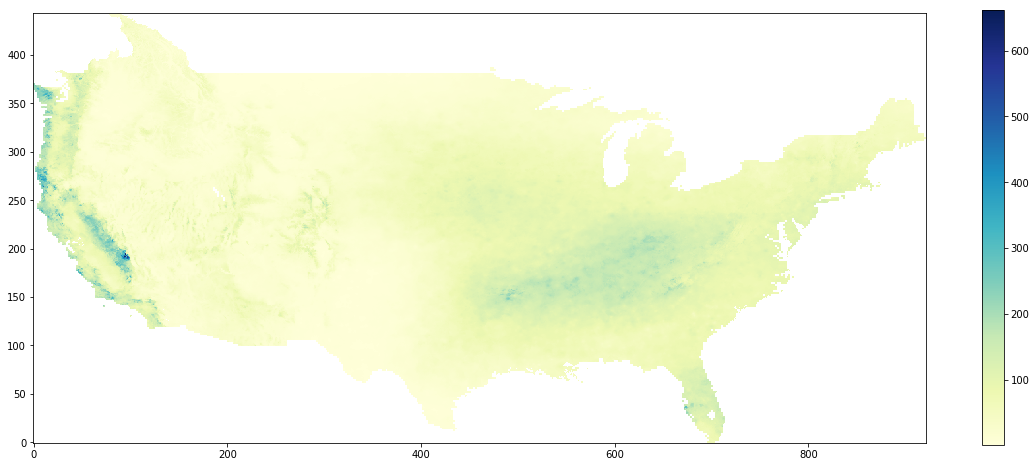

In [30]:
#Plot a map for a selected time slice
plt.figure(figsize=(20,8))
plt.imshow(arrPrecip[38,:,:],origin=(0,0),cmap="YlGnBu")
plt.colorbar();

Now, let's move on to making our own masks. Here

In [31]:
#Display the bounds of each axis
print("Lat:",arrLat.min(),arrLat.max())
print("Lon:",arrLon.min(),arrLon.max())
print("Time:",arrTime.min(),arrTime.max())

Lat: 25.15625 52.84375
Lon: 235.40625 292.96875
Time: 1989-12-24 00:00:00 2005-11-19 00:00:00


In [91]:
#Meshgrid
mlon,mlat = np.meshgrid(arrLon,arrLat)

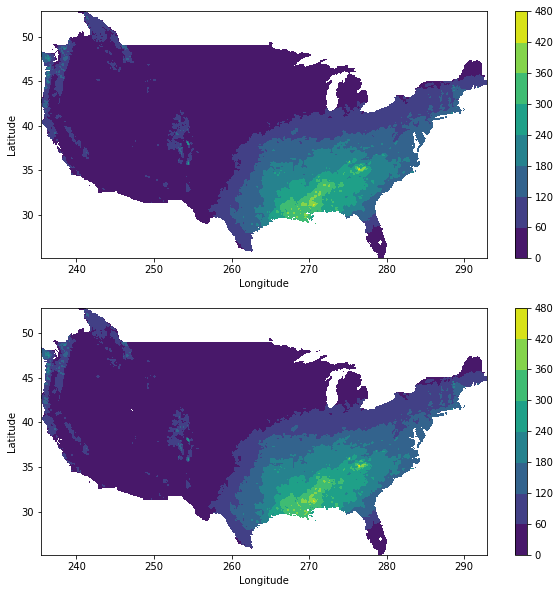

In [102]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.contourf(mlon,mlat,precip[1,:,:],linestyles='none')
plt.colorbar();
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(2,1,2)
plt.contourf(mlon,mlat,precip[1,:,:],linestyles='none')
plt.colorbar();
plt.xlabel('Longitude')
plt.ylabel('Latitude');


In [116]:
arrLat.shape,arrLon.shape,precip.shape

((444,), (922,), (192, 444, 922))

In [140]:
#Lat/lon slices
latMask = (arrLat>30) & (arrLat<31)
lonMask = (arrLon>230) & (arrLon<231)

In [142]:
#Lat/lon slices
latMask = (mlat>30) & (mlat<31)
lonMask = (mlon>230) & (mlon<231)
latMask.shape,lonMask.shape

((444, 922), (444, 922))

In [157]:
arrPrecip

masked_array(data =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
             mask =
 False,
       fill_value = 9.96920996839e+36)

# Calculate summer (JJA) average
Reduce the 3 dimensional precip data to two dimension by averaging over time

In [178]:
avgPrecip = arrPrecip.mean(axis=0)

In [200]:
tSlice = arrPrecip[arrTime >= np.datetime64('1999'),:,:]
tSlice.shape

(109, 444, 922)

In [206]:
nyear = int(ntime/12)
year = np.arange(1995,2006)
precip_JJA = np.zeros((nyear,nlon,nlat))

In [222]:
arrTime.astype(np.datetime64[Y])

NameError: name 'Y' is not defined

In [216]:
year = 1997
yearMask = arrPrecip[arrTime == np.datetime64(str(year)),:,:]
yearMask.shape

(0, 444, 922)

In [209]:
for ii in year:
    #Create the mask
    precip_JJA(ii,:,:) = arrPrecip

1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005


In [177]:
foo = np.broadcast_to(1,arrLat)

ValueError: sequence too large; cannot be greater than 32

In [164]:
#Lat/lon slices
latMask = (arrLat>30) & (arrLat<31)
lonMask = (arrLon>230) & (arrLon<231)
latMask.shape,lonMask.shape

((444,), (922,))

In [170]:
foo = np.ma.masked_where(latMask>30,arrPrecip)
foo.shape

(192, 444, 922)

In [151]:
bigMask = np.ma.mask_or(latMask,lonMask,arrPrecip.mask)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [150]:
foo = np.broadcast_to(bigMask,arrPrecip.shape)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

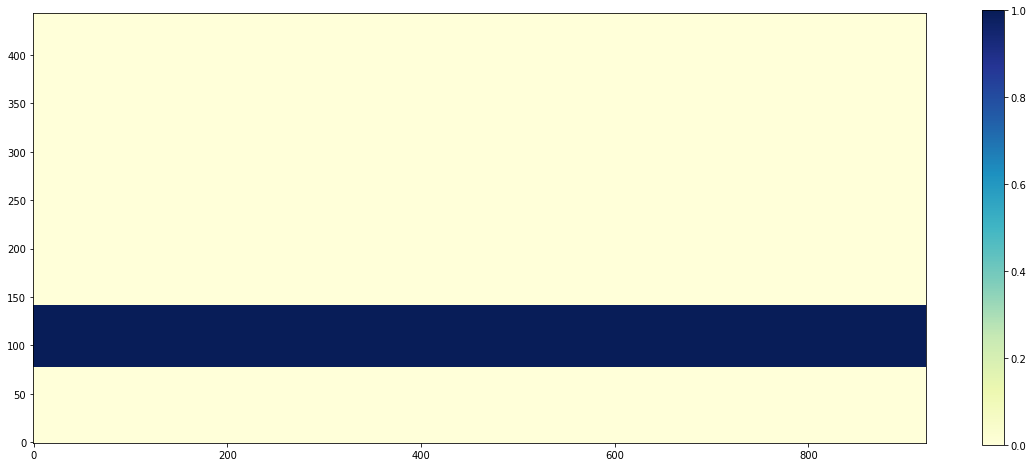

In [139]:
#Plot a map for a selected time slice
plt.figure(figsize=(20,8))
plt.imshow(foo[0,:,:],origin=(0,0),cmap="YlGnBu")
plt.colorbar();

In [53]:
latMask = (latMesh>30) & (latMesh<34)
lonMask = (lonMesh>230) & (lonMesh<235)

In [56]:
#https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
precipX = arrPrecip[0,latMask,lonMask]

IndexError: too many indices for array

In [19]:
arrTime.astype('datetime64[M]')

array(['1989-12', '1990-01', '1990-02', '1990-03', '1990-04', '1990-05',
       '1990-06', '1990-07', '1990-08', '1990-09', '1990-10', '1990-11',
       '1990-12', '1991-01', '1991-02', '1991-03', '1991-04', '1991-05',
       '1991-06', '1991-07', '1991-08', '1991-09', '1991-10', '1991-11',
       '1991-12', '1992-01', '1992-02', '1992-03', '1992-04', '1992-05',
       '1992-06', '1992-07', '1992-08', '1992-09', '1992-10', '1992-11',
       '1992-12', '1993-01', '1993-02', '1993-03', '1993-04', '1993-05',
       '1993-06', '1993-07', '1993-08', '1993-09', '1993-10', '1993-11',
       '1993-12', '1994-01', '1994-02', '1994-03', '1994-04', '1994-05',
       '1994-06', '1994-07', '1994-08', '1994-09', '1994-10', '1994-11',
       '1994-12', '1995-01', '1995-02', '1995-03', '1995-04', '1995-05',
       '1995-06', '1995-07', '1995-08', '1995-09', '1995-10', '1995-11',
       '1995-12', '1996-01', '1996-02', '1996-03', '1996-04', '1996-05',
       '1996-06', '1996-07', '1996-08', '1996-09', 

In [ ]:
arrTime[arrTime<np.datetime64(1995)]

In [ ]:
time2 == np.datetime64('1995')

In [ ]:
pPanel = pd.Panel(rollaxis(a,0)).to_frame()

In [ ]:
#Create mesh grids 
xx,yy = np.meshgrid(lon[:],lat[:])

In [ ]:
xx.shape, yy.shape

In [ ]:
xMask= 

---
---
---

In [ ]:
# return the attribute of the variable precip
units = precip.units
print(units)

---
Because Python has much broader uses than MatLab, we need to use a specific package to handle data arrays. This package is called `NumPy`

In [ ]:
# Import the numpy package
import numpy as np

In [ ]:
# convert variables to NumPy arrays
arrLon = lon[:]
arrLat = lat[:]
arrTime = time[:]
arrPrecip = precip[:]

The `[:]` extracts the values in each netCDF variable into a "masked array". A *masked* array only different from a standard array in that it includes a corresponding Boolean array that indicates which cells have values. 

In [ ]:
# Show the data type of the arrPrecip
type(arrPrecip)

In [ ]:
#Show the shape of the array
arrPrecip.mask.shape

In [ ]:
arrPrecip.size, arrPrecip.mask.size

...back to our MatLab analog, but now working with the arrPrecip numpy array in place of the NetCDF variable

In [ ]:
# replace fillvalues with nan(not a number)
##-->We don't have to do this as the arrays are masked already!##
print("Min of masked data = ",arrPrecip[arrPrecip.mask == False].min())
print("Min of all data =",arrPrecip.data.min())

In [ ]:
# calculate summer(JJA) average
nyear = int(ntime / 12)
year = np.arange(1990,2006)
precip_JJA = np.zeros((nlon,nlat,nyear))
for ii in year:
    startTime = 6+12*(ii-1)
    endTime = 8+12*(ii-1)
    #precip_JJA(ii,:,:) = precip()
    arrPrecip(6+12*(ii-1):8+12*(ii-1)),:,:)

In [ ]:
year = 1995
startTime = 6+12*(year-1)
endTime = 8+12*(year-1)
arrPrecip[startTime:endTime,:,:].mean()

In [ ]:
arrPrecip.shape

In [ ]:
arrPrecip[:,250,500].data
